<b>Python demo code for Authority-Shift Clustering.</b> This clustering method has been presented in:

Minsu Cho and Kyoung Mu Lee, \
Authority-Shift Clustering: \
Hierarchical Clustering by Authority Seeking on Graphs, \
Proc. Computer Vision and Pattern Recognition (CVPR), 2010. 

In [85]:
import numpy as np
import scipy as sp
import scipy.spatial
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import csv

<b>Find sink for each node by traversals.</b>

Input: shifted indexes \
Output: sink indexes

In [2]:
def find_sink(shifted_idx):
    
    sinkIdx = np.zeros(shifted_idx.shape[0], dtype=int)  
    nNode = len(shifted_idx)
    
    # Traverse for each node
    for i in range(nNode):
        sinkIdx = find_sink_recur(i, shifted_idx, sinkIdx)
    
    return sinkIdx

def find_sink_recur(cur_idx, shifted_idx, sinkIdx):

    # if a sink
    if cur_idx == shifted_idx[cur_idx]:
        
        sinkIdx[cur_idx] = cur_idx
        
    else:
        
        # if not labelled, dive into recursion
        if sinkIdx[shifted_idx[cur_idx]] == 0:
            
            # footmark for a cyclic sink
            sinkIdx[cur_idx] = cur_idx
            sinkIdx = find_sink_recur(shifted_idx[cur_idx], shifted_idx, sinkIdx)
        
        # inherit the sink label
        sinkIdx[cur_idx] = sinkIdx[shifted_idx[cur_idx]]
        
    return sinkIdx      

<b>Compute the PPR matrix, whose ith row is PPR(i) </b>

Input: \
Output:

In [12]:
def computePPRmatrix(Brw, c):
    
    nSize = Brw.shape[0]
    
    # make personalization matrix
    #M_pers = sp.sparse.csr_matrix.todense(sp.sparse.eye(nSize))
    M_pers = sp.sparse.eye(nSize)
    
    # nSize by nSeed
    #W_PPR = np.linalg.lstsq((M_pers - c*Brw), M_pers, rcond=None)[0] * (1-c)
    W_PPR = np.linalg.inv(M_pers - c*Brw) * (1-c)
    
    # Bias substraction
    W_PPR = W_PPR - (M_pers * (1-c))
    
    # Normalization
    normM = np.zeros(W_PPR.shape)
    np.fill_diagonal(normM, 1 / W_PPR.sum(axis=0))
    # misteriously don't work
    #np.diag(1 / W_PPR.sum(axis=0)) #axis=0 is column sum
    W_PPR = np.matmul(W_PPR,normM)
    
    return W_PPR

<b>Compute the affinity matrix and normalize it such that the sum for each column is equal to one.</b>

Input: data as feature_dim x num of data \
Output: 

In [9]:
def computeAffinityNorm(data, scale=None, order=None):
    
    #Condensed distance matrix between points
    distances = sp.spatial.distance.pdist(data)
    
    #Converts between condensed distance matrices and square distance matrices
    distances = sp.spatial.distance.squareform(distances)
    
    if scale is None:
        scale = 0.05 * np.max(distances)

    if order is None:
        order = 2
        
    W = np.exp(-(distances/scale)**order);
    
    # Normalization

    nPoints = W.shape[0]
    
    # column-stochastic matrix
    Prw = W;
    for i in range(nPoints):
        Prw[i,i] = 0
        
    D = np.diag(np.sum(W, axis=0))
    
    Prw = np.matmul(Prw, np.linalg.inv(D))
    
    return Prw

<b>Authority-Shift clustering algorithm</b>

In [10]:
def authorityShift(points, Prw, c, k, itermax):
    
    W_PPR_initial = computePPRmatrix(Prw, c)
    
    #  initiaization for authority-shift
    W_PPR_reduced = np.array(W_PPR_initial)                 # initial PPRs for the current layer
    W_PPR_nOrder = np.array(W_PPR_initial)                  # nth order PPRs in the current layer
    
    nSize = Prw.shape[0]
    
    authIdx = np.array([i for i in range(nSize)])           # current index set of authority nodes (super nodes)
    szOfAuthIdx = np.array([1 for i in range(nSize)])       # member size for each super node
    authIdx_all = np.array([i for i in range(nSize)])       # current authority index for each initial node
    nPPROrder = 1                                           # PPR order for the current layer

    for kIter in range(itermax):
        
        # authority-shifting: where is my authority node?
        # finding the maximum along each column is equal to forward propagation
        shiftVal = (np.amax(W_PPR_nOrder, axis=0)).flatten()
        elementIdx = (np.argmax(W_PPR_nOrder, axis=0)).flatten()
        
        # find authority-sink for each node
        sink_elementIdx = find_sink(elementIdx)
        final_authIdx = np.array([authIdx[i] for i in sink_elementIdx])
        
        # code for normal arrays
        # shifted_idx = np.nonzero([final_authIdx[i] != authIdx[i] for i in range(len(final_authIdx))])[0]
        
        # code for np.arrays
        shifted_idx = np.nonzero([final_authIdx != authIdx])[1]
        new_seedList = np.unique(final_authIdx)   # np.unique returns an array already sorted 
        
        if len(shifted_idx) == 0:
            
            # PPR propagation for n-th order PPR
            W_PPR_nOrder = np.matmul(W_PPR_reduced,W_PPR_nOrder) 
            nPPROrder = nPPROrder + 1
            
        else:
        
            # supernode aggregation and matrix reduction
            # edit authIdx_all
            for cIdx in shifted_idx:
                # code for normal arrays
                #for idx in np.nonzero([authIdx_all[i] == authIdx[cIdx] for i in range(len(authIdx_all))])[0]:
                #    authIdx_all[idx] = final_authIdx[cIdx]
                
                #code for np.arrays
                authIdx_all[authIdx_all == authIdx[cIdx]] = final_authIdx[cIdx]
                    
            # start updating W_PPR_reduced
            tmp_W_PPR_reduced = np.zeros((len(authIdx),len(new_seedList)))
            new_szOfAuthIdx = np.zeros(len(new_seedList), dtype=int)
            
            # First, row-wise summation considering sizes of supernodes
            for jIter in range(len(new_seedList)):

                tmp_seedListIdx = np.nonzero(final_authIdx == new_seedList[jIter])[0]
                new_szOfAuthIdx[jIter] = np.sum([szOfAuthIdx[i] for i in tmp_seedListIdx])
                
                if len(tmp_seedListIdx) > 1:
                    
                    tmp_Norm = np.diag(szOfAuthIdx[tmp_seedListIdx]) / new_szOfAuthIdx[jIter]
                    tmp_W_PPR_reduced[:,jIter] = np.sum(np.matmul(W_PPR_reduced[:,tmp_seedListIdx], tmp_Norm), axis=1)
                    
                else:
                    # only one element accessed with 0 index
                    tmp_W_PPR_reduced[:,jIter] = W_PPR_reduced[:,tmp_seedListIdx[0]]
                    
            
            # Second, column-wise summation, just sum!
            new_W_PPR_reduced = np.zeros((len(new_seedList),len(new_seedList)))
            
            for jIter in range(len(new_seedList)):

                tmp_seedListIdx = np.nonzero(final_authIdx == new_seedList[jIter])[0]
                new_W_PPR_reduced[jIter,:] = np.sum(tmp_W_PPR_reduced[tmp_seedListIdx,:] , axis=0)
                
            W_PPR_reduced = new_W_PPR_reduced
            W_PPR_nOrder = new_W_PPR_reduced
            seedList = new_seedList
            authIdx = new_seedList
            szOfAuthIdx = new_szOfAuthIdx
            
            # reset the PPR order
            nPPROrder = 1;
            
        # stop if the number of cluster is equal to or less then k 
        if len(authIdx) <= k:
            break
    
    # return the final result
    return authIdx_all

(500, 500)


<Figure size 720x432 with 0 Axes>

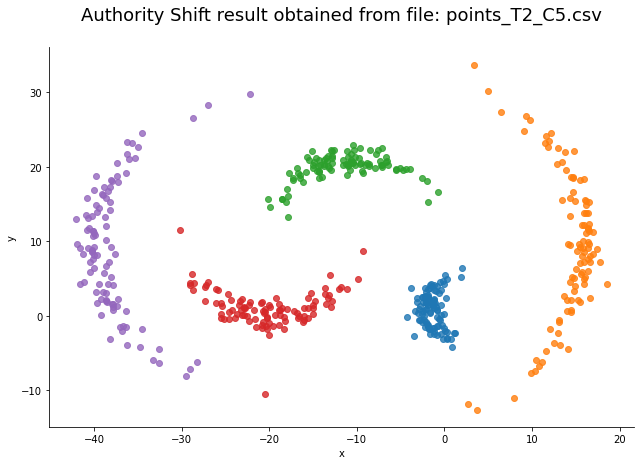

(320, 320)


<Figure size 720x432 with 0 Axes>

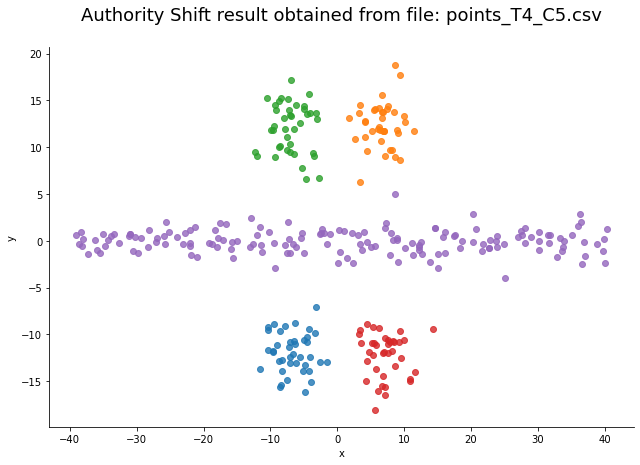

(320, 320)


<Figure size 720x432 with 0 Axes>

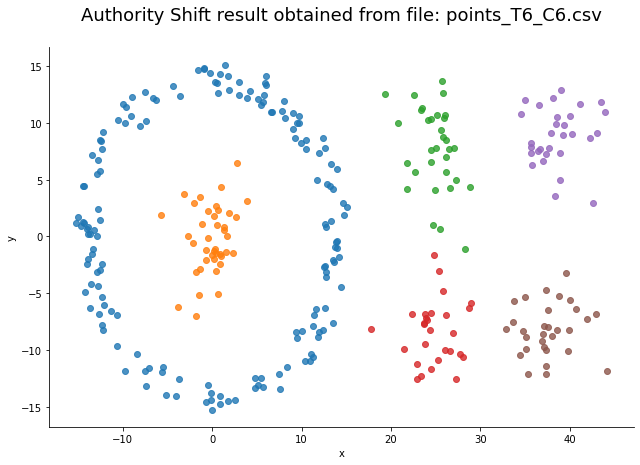

(440, 440)


<Figure size 720x432 with 0 Axes>

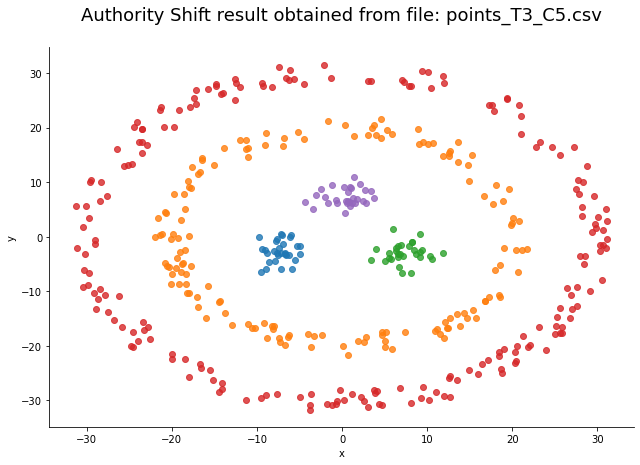

(280, 280)


<Figure size 720x432 with 0 Axes>

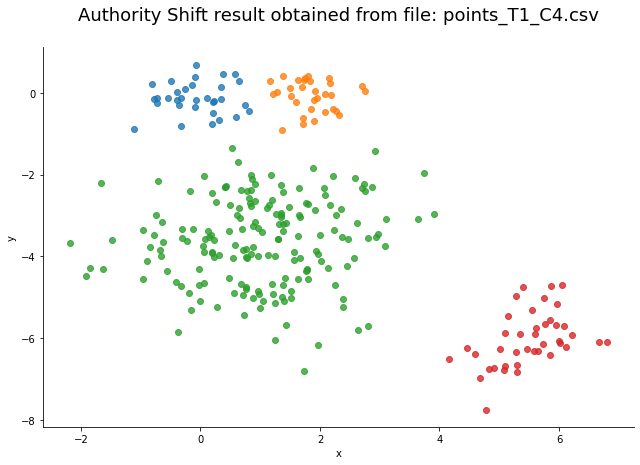

(350, 350)


<Figure size 720x432 with 0 Axes>

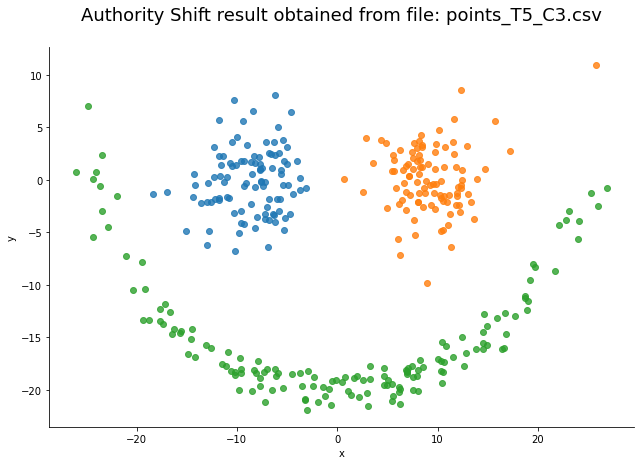

In [92]:
import os

directory = 'data/simple_clusters/'
files = os.listdir(directory)

# Parameters for the Authority shift algorithm

authorityshift_c = 0.85
itermax = 1000

for file_name in files:
    
    # Extract the number of clusters k from the file name
    start = file_name.find('_C') + 2
    end = file_name.find('.csv')
    k = int(file_name[start:end])

    file = csv.reader(open(directory+file_name), delimiter=',')
    points = np.array(list(file), dtype='float')

    Prw =  computeAffinityNorm(points)
    
    labels = authorityShift(points, Prw, authorityshift_c, k, itermax)
    
    labeled_points = np.zeros((points.shape[0], points.shape[1] + 1))
    labeled_points[:, 0:2] = points
    labeled_points[:, 2] = labels
    
    data = pd.DataFrame(labeled_points, columns=['x', 'y','label'])
    
    #sns.lmplot(data=data, x='x', y='y', hue='label', height = 6, aspect = 1.5, legend=False, fit_reg=False).fig.suptitle("Authority Shift result obtained from file: " + file + '\n', fontsize=18)
    
    plt.figure(figsize=(10,6))
    sns.lmplot(data=data, x='x', y='y', hue='label', height = 6, aspect = 1.5, legend=False, fit_reg=False)
    plt.title("Authority Shift result obtained from file: " + file_name + '\n', fontsize=18)
    plt.show()
    

In [97]:
file_name = 'data/s1.txt'


with open(file_name) as f:
    lines = f.readlines()

edges = []

for line in lines:
    #edges.append([int(line[4:10]), int(line[14:20])])
    edges.append(line[:-1])
    
G = nx.parse_edgelist(edges, nodetype=int)

distances = nx.all_pairs_shortest_path_length(G)
print(distances[556737])
    




TypeError: 'generator' object is not subscriptable